In [1]:
# Validation of the steady-state simulation - Case 1: MLP
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_kernels=200 # Number of kernels in convolutional network
kernel_size1=3
strides=1
n_units=128 # Number of units in the hidden layer of the MLP network
input_size = 100 # Size of input for the network (100 coefficients and 3 other parameters, AoA, h, beta)
lr = 1e-03 # Learning rate of the network
val_rate = 0.2
test_rate=0.1 # Defines the ratio of training dataset and test dataset
n_data = 16 # Number of txt files from which the aerodynamic coefficients are extracted
batch_size = 20 # Mini-batch size

In [3]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [4]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
t = 0.02 * h # Thickness of the Gurney flaps
alpha = np.linspace(0, 16, 9).reshape((9,1)) # Angles of attack
beta = np.linspace(30, 90, 5).reshape((5,1))

In [5]:
h = h.reshape((-1,1))
t = t.reshape((-1,1))

In [6]:
n_alpha = alpha.shape[0] # Number of the angles of attack
n_beta = beta.shape[0] # Number of the Gurney flap inclination
n_h = h.shape[0] # Number of the height of the Gurney flaps
n_cases = n_data * n_alpha # Total number of cases(Number of geometries * Number of angles of attack)

In [7]:
## Creating input dataset - mask
mask_dir = main_directory + '\\aeroCNN2Mask'
os.chdir(mask_dir)
mask_list = os.listdir(mask_dir)
mask_target = [file for file in mask_list if file.endswith('.csv')]

In [8]:
mask_df = pd.DataFrame()
for file in mask_target:
    data = pd.read_csv(file, header=None)
    mask_df = pd.concat([mask_df, data], axis=0)

In [9]:
x = mask_df.iloc[:,:].values

In [10]:
x_alligned = np.zeros((x.shape[0],x.shape[1]))
for i in range(0,144*2):
    if i%2==0:
        x_alligned[i*100:(i+1)*100,:] = x[i*100:(i+1)*100,:]
    else:
        x_alligned[i*100:(i+1)*100,:] = x[i*100:(i+1)*100,:].T


In [11]:
x = x_alligned.reshape((16*9,2,input_size,input_size))

In [12]:
## Creating output dataset - Cl and Cd
files_orig = os.listdir(main_directory)
files_target = [file for file in files_orig if file.endswith('.txt')]
os.chdir(main_directory)

In [13]:
target_df = pd.DataFrame()
for file in files_target:
    data = pd.read_table(file, header=None)
    target_df = pd.concat([target_df, data], axis=0)

In [14]:
target_c3 = target_df.iloc[:,3].values # Cd values
target_c4 = target_df.iloc[:,4].values# Cl values

In [15]:
y = np.hstack((target_c3.reshape((-1,1)), target_c4.reshape((-1,1))))

In [16]:
y.shape

(144, 2)

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_rate, random_state=1)

In [18]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=test_rate, random_state=1)

In [19]:
x_train.shape

(116, 2, 100, 100)

In [20]:
y_train.shape

(116, 2)

In [21]:
tf.keras.backend.set_image_data_format('channels_first')

In [22]:
input_image = tf.keras.Input(shape=(2, input_size, input_size))

x_conv = tf.keras.layers.Conv2D(n_kernels, (kernel_size1, kernel_size1), strides=(strides, strides),
                                activation='relu', padding='same'
                                )(input_image)
x_ = tf.keras.layers.MaxPooling2D((2,2))(x_conv)
x_conv = tf.keras.layers.Conv2D(n_kernels, (kernel_size1, kernel_size1), strides=(strides, strides),
                                activation='relu', padding='same'
                                )(input_image)
x_ = tf.keras.layers.MaxPooling2D((2,2))(x_conv)
x_conv = tf.keras.layers.Conv2D(n_kernels, (kernel_size1, kernel_size1), strides=(strides, strides),
                                activation='relu', padding='same'
                                )(input_image)
x_ = tf.keras.layers.MaxPooling2D((2,2))(x_conv)
x_flat = tf.keras.layers.Flatten()(x_)
x_fc1 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1')(x_flat)
x_fc2 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc2')(x_fc1)
x_fc3 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc3')(x_fc2)
x_fc4 = tf.keras.layers.Dense(units=16, activation='relu', name='fc4')(x_fc3)

output_data = tf.keras.layers.Dense(units=2, activation='linear', name='outputLayer')(x_fc4)
# AeroCNN-II based
model = tf.keras.Model(input_image, output_data)

In [23]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2, 100, 100)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 200, 100, 100)     3800      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 200, 50, 50)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 500000)            0         
                                                                 
 fc1 (Dense)                 (None, 128)               64000128  
                                                                 
 fc2 (Dense)                 (None, 128)               16512     
                                                             

In [24]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [25]:
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=200, min_delta=6e-7,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=100, factor=0.5,
                                          min_delta = 1e-07, min_lr=1e-06,
                                          verbose=1)

In [26]:
STEP_SIZE_TRAIN = len(x_train)//batch_size

In [27]:
start = datetime.datetime.now()
history = model.fit(x_train, y_train, validation_data=[x_val, y_val], batch_size=batch_size,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    epochs=5000, shuffle=True, callbacks=[es, rp])
end = datetime.datetime.now()

Epoch 1/5000
5/5 [==============================] - 19s 431ms/step - loss: 139.6810 - rmse: 11.8187 - val_loss: 140.6013 - val_rmse: 11.8575 - lr: 0.0010
Epoch 2/5000
5/5 [==============================] - 0s 73ms/step - loss: 58.1236 - rmse: 7.6239 - val_loss: 6.0322 - val_rmse: 2.4561 - lr: 0.0010
Epoch 3/5000
5/5 [==============================] - 0s 84ms/step - loss: 5.0731 - rmse: 2.2524 - val_loss: 0.9977 - val_rmse: 0.9988 - lr: 0.0010
Epoch 4/5000
5/5 [==============================] - 0s 63ms/step - loss: 1.6857 - rmse: 1.2983 - val_loss: 0.6966 - val_rmse: 0.8346 - lr: 0.0010
Epoch 5/5000
5/5 [==============================] - 0s 59ms/step - loss: 0.7123 - rmse: 0.8439 - val_loss: 0.6690 - val_rmse: 0.8179 - lr: 0.0010
Epoch 6/5000
5/5 [==============================] - 0s 68ms/step - loss: 0.6763 - rmse: 0.8224 - val_loss: 0.6669 - val_rmse: 0.8166 - lr: 0.0010
Epoch 7/5000
5/5 [==============================] - 0s 67ms/step - loss: 0.6647 - rmse: 0.8153 - val_loss: 0.6673 -

Epoch 57/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.4983 - rmse: 0.7059 - val_loss: 0.5489 - val_rmse: 0.7409 - lr: 0.0010
Epoch 58/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.5485 - rmse: 0.7406 - val_loss: 0.5557 - val_rmse: 0.7454 - lr: 0.0010
Epoch 59/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.5433 - rmse: 0.7371 - val_loss: 0.5472 - val_rmse: 0.7397 - lr: 0.0010
Epoch 60/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.4994 - rmse: 0.7067 - val_loss: 0.5459 - val_rmse: 0.7388 - lr: 0.0010
Epoch 61/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.5116 - rmse: 0.7153 - val_loss: 0.5449 - val_rmse: 0.7382 - lr: 0.0010
Epoch 62/5000
5/5 [==============================] - 0s 19ms/step - loss: 0.5550 - rmse: 0.7450 - val_loss: 0.5381 - val_rmse: 0.7336 - lr: 0.0010
Epoch 63/5000
5/5 [==============================] - 0s 48ms/step - loss: 0.4857 - rmse: 0.6969 - val_loss: 0.5407 - v

Epoch 113/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.3923 - rmse: 0.6264 - val_loss: 0.4157 - val_rmse: 0.6448 - lr: 0.0010
Epoch 114/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.3958 - rmse: 0.6291 - val_loss: 0.4142 - val_rmse: 0.6436 - lr: 0.0010
Epoch 115/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.3950 - rmse: 0.6285 - val_loss: 0.4125 - val_rmse: 0.6423 - lr: 0.0010
Epoch 116/5000
5/5 [==============================] - 0s 48ms/step - loss: 0.3357 - rmse: 0.5794 - val_loss: 0.4089 - val_rmse: 0.6395 - lr: 0.0010
Epoch 117/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.4608 - rmse: 0.6788 - val_loss: 0.4084 - val_rmse: 0.6391 - lr: 0.0010
Epoch 118/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.3492 - rmse: 0.5910 - val_loss: 0.4044 - val_rmse: 0.6359 - lr: 0.0010
Epoch 119/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.3901 - rmse: 0.6246 - val_loss: 0.4

5/5 [==============================] - 0s 47ms/step - loss: 0.2743 - rmse: 0.5237 - val_loss: 0.3071 - val_rmse: 0.5541 - lr: 0.0010
Epoch 169/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.2817 - rmse: 0.5307 - val_loss: 0.3076 - val_rmse: 0.5547 - lr: 0.0010
Epoch 170/5000
5/5 [==============================] - 0s 57ms/step - loss: 0.2706 - rmse: 0.5202 - val_loss: 0.3046 - val_rmse: 0.5519 - lr: 0.0010
Epoch 171/5000
5/5 [==============================] - 0s 17ms/step - loss: 0.2971 - rmse: 0.5450 - val_loss: 0.3032 - val_rmse: 0.5506 - lr: 0.0010
Epoch 172/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.3115 - rmse: 0.5581 - val_loss: 0.3007 - val_rmse: 0.5484 - lr: 0.0010
Epoch 173/5000
5/5 [==============================] - 0s 56ms/step - loss: 0.2679 - rmse: 0.5176 - val_loss: 0.3011 - val_rmse: 0.5488 - lr: 0.0010
Epoch 174/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.2737 - rmse: 0.5232 - val_loss: 0.2964 - val_rmse:

5/5 [==============================] - 0s 18ms/step - loss: 0.2099 - rmse: 0.4582 - val_loss: 0.2277 - val_rmse: 0.4771 - lr: 0.0010
Epoch 224/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.2152 - rmse: 0.4639 - val_loss: 0.2312 - val_rmse: 0.4809 - lr: 0.0010
Epoch 225/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.2192 - rmse: 0.4682 - val_loss: 0.2295 - val_rmse: 0.4791 - lr: 0.0010
Epoch 226/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.2257 - rmse: 0.4751 - val_loss: 0.2235 - val_rmse: 0.4727 - lr: 0.0010
Epoch 227/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.2209 - rmse: 0.4700 - val_loss: 0.2391 - val_rmse: 0.4890 - lr: 0.0010
Epoch 228/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.2071 - rmse: 0.4551 - val_loss: 0.2213 - val_rmse: 0.4704 - lr: 0.0010
Epoch 229/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.1968 - rmse: 0.4436 - val_loss: 0.2249 - val_rmse:

5/5 [==============================] - 0s 19ms/step - loss: 0.1770 - rmse: 0.4207 - val_loss: 0.1818 - val_rmse: 0.4264 - lr: 0.0010
Epoch 279/5000
5/5 [==============================] - 0s 46ms/step - loss: 0.1373 - rmse: 0.3705 - val_loss: 0.1808 - val_rmse: 0.4252 - lr: 0.0010
Epoch 280/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.1540 - rmse: 0.3924 - val_loss: 0.1805 - val_rmse: 0.4249 - lr: 0.0010
Epoch 281/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.1658 - rmse: 0.4072 - val_loss: 0.1796 - val_rmse: 0.4238 - lr: 0.0010
Epoch 282/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.1731 - rmse: 0.4160 - val_loss: 0.1790 - val_rmse: 0.4231 - lr: 0.0010
Epoch 283/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.1599 - rmse: 0.3999 - val_loss: 0.1782 - val_rmse: 0.4222 - lr: 0.0010
Epoch 284/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.1640 - rmse: 0.4050 - val_loss: 0.1776 - val_rmse:

5/5 [==============================] - 0s 18ms/step - loss: 0.1200 - rmse: 0.3464 - val_loss: 0.1536 - val_rmse: 0.3920 - lr: 0.0010
Epoch 334/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.1426 - rmse: 0.3777 - val_loss: 0.1533 - val_rmse: 0.3916 - lr: 0.0010
Epoch 335/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.1371 - rmse: 0.3703 - val_loss: 0.1525 - val_rmse: 0.3906 - lr: 0.0010
Epoch 336/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.1339 - rmse: 0.3660 - val_loss: 0.1526 - val_rmse: 0.3907 - lr: 0.0010
Epoch 337/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.1274 - rmse: 0.3569 - val_loss: 0.1520 - val_rmse: 0.3898 - lr: 0.0010
Epoch 338/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.1336 - rmse: 0.3655 - val_loss: 0.1518 - val_rmse: 0.3896 - lr: 0.0010
Epoch 339/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.1329 - rmse: 0.3645 - val_loss: 0.1510 - val_rmse:

5/5 [==============================] - 0s 19ms/step - loss: 0.1196 - rmse: 0.3459 - val_loss: 0.1403 - val_rmse: 0.3746 - lr: 0.0010
Epoch 389/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.1213 - rmse: 0.3483 - val_loss: 0.1366 - val_rmse: 0.3696 - lr: 0.0010
Epoch 390/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.1126 - rmse: 0.3356 - val_loss: 0.1397 - val_rmse: 0.3738 - lr: 0.0010
Epoch 391/5000
5/5 [==============================] - 0s 19ms/step - loss: 0.1202 - rmse: 0.3467 - val_loss: 0.1371 - val_rmse: 0.3703 - lr: 0.0010
Epoch 392/5000
5/5 [==============================] - 0s 50ms/step - loss: 0.1075 - rmse: 0.3279 - val_loss: 0.1386 - val_rmse: 0.3723 - lr: 0.0010
Epoch 393/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.1256 - rmse: 0.3544 - val_loss: 0.1377 - val_rmse: 0.3711 - lr: 0.0010
Epoch 394/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.1192 - rmse: 0.3452 - val_loss: 0.1382 - val_rmse:

5/5 [==============================] - 0s 18ms/step - loss: 0.1077 - rmse: 0.3281 - val_loss: 0.1281 - val_rmse: 0.3579 - lr: 0.0010
Epoch 444/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.1228 - rmse: 0.3504 - val_loss: 0.1332 - val_rmse: 0.3650 - lr: 0.0010
Epoch 445/5000
5/5 [==============================] - 0s 19ms/step - loss: 0.1169 - rmse: 0.3419 - val_loss: 0.1266 - val_rmse: 0.3558 - lr: 0.0010
Epoch 446/5000
5/5 [==============================] - 0s 19ms/step - loss: 0.1094 - rmse: 0.3308 - val_loss: 0.1393 - val_rmse: 0.3732 - lr: 0.0010
Epoch 447/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.1132 - rmse: 0.3364 - val_loss: 0.1288 - val_rmse: 0.3588 - lr: 0.0010
Epoch 448/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.1286 - rmse: 0.3586 - val_loss: 0.1383 - val_rmse: 0.3719 - lr: 0.0010
Epoch 449/5000
5/5 [==============================] - 0s 58ms/step - loss: 0.1008 - rmse: 0.3176 - val_loss: 0.1322 - val_rmse:

5/5 [==============================] - 0s 18ms/step - loss: 0.1232 - rmse: 0.3509 - val_loss: 0.1431 - val_rmse: 0.3783 - lr: 0.0010
Epoch 499/5000
5/5 [==============================] - 0s 19ms/step - loss: 0.1223 - rmse: 0.3497 - val_loss: 0.1430 - val_rmse: 0.3781 - lr: 0.0010
Epoch 500/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.1277 - rmse: 0.3574 - val_loss: 0.1429 - val_rmse: 0.3780 - lr: 0.0010
Epoch 501/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.1279 - rmse: 0.3576 - val_loss: 0.1428 - val_rmse: 0.3778 - lr: 0.0010
Epoch 502/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.1131 - rmse: 0.3363 - val_loss: 0.1427 - val_rmse: 0.3777 - lr: 0.0010
Epoch 503/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.1218 - rmse: 0.3490 - val_loss: 0.1426 - val_rmse: 0.3776 - lr: 0.0010
Epoch 504/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.1283 - rmse: 0.3582 - val_loss: 0.1425 - val_rmse:

5/5 [==============================] - 0s 18ms/step - loss: 0.1091 - rmse: 0.3303 - val_loss: 0.1399 - val_rmse: 0.3740 - lr: 0.0010
Epoch 554/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.1267 - rmse: 0.3560 - val_loss: 0.1399 - val_rmse: 0.3740 - lr: 0.0010
Epoch 555/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.1182 - rmse: 0.3438 - val_loss: 0.1399 - val_rmse: 0.3740 - lr: 0.0010
Epoch 556/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.1256 - rmse: 0.3543 - val_loss: 0.1398 - val_rmse: 0.3739 - lr: 0.0010
Epoch 557/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.1206 - rmse: 0.3472 - val_loss: 0.1398 - val_rmse: 0.3739 - lr: 0.0010
Epoch 558/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.1198 - rmse: 0.3461 - val_loss: 0.1398 - val_rmse: 0.3739 - lr: 0.0010
Epoch 559/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.1173 - rmse: 0.3425 - val_loss: 0.1398 - val_rmse:

Epoch 607/5000
5/5 [==============================] - 0s 19ms/step - loss: 0.1228 - rmse: 0.3505 - val_loss: 0.1394 - val_rmse: 0.3733 - lr: 5.0000e-04
Epoch 608/5000
5/5 [==============================] - 0s 19ms/step - loss: 0.1187 - rmse: 0.3446 - val_loss: 0.1394 - val_rmse: 0.3733 - lr: 5.0000e-04
Epoch 609/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.1104 - rmse: 0.3322 - val_loss: 0.1394 - val_rmse: 0.3733 - lr: 5.0000e-04
Epoch 610/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.1204 - rmse: 0.3470 - val_loss: 0.1394 - val_rmse: 0.3733 - lr: 5.0000e-04
Epoch 611/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.1214 - rmse: 0.3485 - val_loss: 0.1394 - val_rmse: 0.3733 - lr: 5.0000e-04
Epoch 612/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.1208 - rmse: 0.3476 - val_loss: 0.1394 - val_rmse: 0.3733 - lr: 5.0000e-04
Epoch 613/5000
5/5 [==============================] - 0s 19ms/step - loss: 0.1223 - rmse

Epoch 661/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.1240 - rmse: 0.3522 - val_loss: 0.1393 - val_rmse: 0.3732 - lr: 5.0000e-04
Epoch 662/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.1208 - rmse: 0.3475 - val_loss: 0.1393 - val_rmse: 0.3732 - lr: 5.0000e-04
Epoch 663/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.1075 - rmse: 0.3279 - val_loss: 0.1393 - val_rmse: 0.3732 - lr: 5.0000e-04
Epoch 664/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.1231 - rmse: 0.3508 - val_loss: 0.1393 - val_rmse: 0.3732 - lr: 5.0000e-04
Epoch 665/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.1139 - rmse: 0.3375 - val_loss: 0.1393 - val_rmse: 0.3732 - lr: 5.0000e-04
Epoch 666/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.1239 - rmse: 0.3520 - val_loss: 0.1393 - val_rmse: 0.3732 - lr: 5.0000e-04
Epoch 667/5000
5/5 [==============================] - 0s 18ms/step - loss: 0.1197 - rmse

In [28]:
time = end - start
print("Training time:", time)

Training time: 0:01:25.120410


In [29]:
storage_dir = "D:\\VAWT_data\\flap_steady\\flap_steady\\result\\"+"20221120AeroCNN_II_revised\\test"+str(test_rate)
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

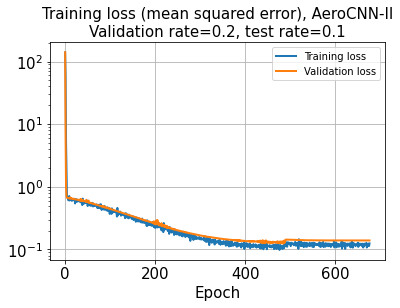

In [30]:
hist = history.history
plt.plot(hist['loss'], lw=2)
plt.plot(hist['val_loss'], lw=2)
plt.title('Training loss (mean squared error), AeroCNN-II\nValidation rate={0}, test rate={1}'.format(val_rate, test_rate), size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(['Training loss','Validation loss'])
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

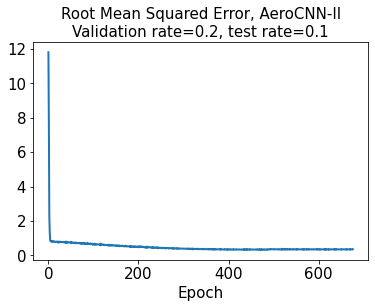

In [31]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error, AeroCNN-II\nValidation rate={0}, test rate={1}'.format(val_rate, test_rate), size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

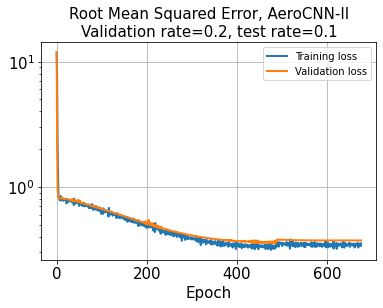

In [32]:
plt.plot(hist['rmse'], lw=2)
plt.plot(hist['val_rmse'], lw=2)
plt.title('Root Mean Squared Error, AeroCNN-II\nValidation rate={0}, test rate={1}'.format(val_rate, test_rate), size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(['Training loss','Validation loss'])
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [33]:
train_results = model.evaluate(x_train, y_train)

4/4 [==============================] - 0s 6ms/step - loss: 0.1110 - rmse: 0.3332


In [34]:
test_results = model.evaluate(x_test, y_test)

1/1 [==============================] - 0s 39ms/step - loss: 0.0497 - rmse: 0.2229


In [35]:
decoded_train = model.predict(x_train)
decoded_val = model.predict(x_val)
decoded_test = model.predict(x_test)

1/1 [==============================] - 0s 16ms/step


In [36]:
model_directory = "D:\\TrainedModels\\20221119"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20221119steadyValidation_AeroCNN_II_val"+str(val_rate)+"_test"+str(test_rate)+ "_" + str(n_units) +"units_normalized.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [37]:
error_train_abs = np.abs(decoded_train - y_train)

In [38]:
error_val_abs = np.abs(decoded_val - y_val)

In [39]:
error_test_abs = np.abs(decoded_test - y_test)

In [40]:
os.chdir(storage_dir)

In [41]:
l2_error_train = np.sqrt(np.sum((decoded_train - y_train)**2) / np.sum(y_train**2))
print(l2_error_train)

0.3901775410141268


In [42]:
l2_error_val = np.sqrt(np.sum((decoded_val - y_val)**2) / np.sum(y_val**2))
print(l2_error_val)

0.4264194521113362


In [43]:
l2_error_test = np.sqrt(np.sum((decoded_test - y_test)**2) / np.sum(y_test**2))
print(l2_error_test)

0.25767190638718246


In [44]:
l2_error_Cd_train = np.sqrt(np.sum((decoded_train[:,0] - y_train[:,0])**2) / np.sum(y_train[:,0]**2))
print(l2_error_Cd_train)

1.1892071357407399


In [45]:
l2_error_Cl_train = np.sqrt(np.sum((decoded_train[:,1] - y_train[:,1])**2) / np.sum(y_train[:,1]**2))
print(l2_error_Cl_train)

0.3879444005028891


In [46]:
l2_error_Cd_val = np.sqrt(np.sum((decoded_val[:,0] - y_val[:,0])**2) / np.sum(y_val[:,0]**2))
print(l2_error_Cd_val)

0.849848427555373


In [47]:
l2_error_Cl_val = np.sqrt(np.sum((decoded_val[:,1] - y_val[:,1])**2) / np.sum(y_val[:,1]**2))
print(l2_error_Cl_val)

0.42563362625249884


In [48]:
l2_error_Cd_test = np.sqrt(np.sum((decoded_test[:,0] - y_test[:,0])**2) / np.sum(y_test[:,0]**2))
print(l2_error_Cd_test)

1.2573511969095608


In [49]:
l2_error_Cl_test = np.sqrt(np.sum((decoded_test[:,1] - y_test[:,1])**2) / np.sum(y_test[:,1]**2))
print(l2_error_Cl_test)

0.254690057845771


In [50]:
l2_error_train_list = []
for i in range(0, len(x_train)):
    l2_error_train_data = np.sqrt(np.sum((decoded_train[i] - y_train[i])**2) / np.sum(y_train[i]**2))
    l2_error_train_list.append(l2_error_train_data)

In [51]:
l2_error_val_list = []
for i in range(0, len(x_val)):
    l2_error_val_data = np.sqrt(np.sum((decoded_val[i] - y_val[i])**2) / np.sum(y_val[i]**2))
    l2_error_val_list.append(l2_error_val_data)

In [52]:
l2_error_test_list = []
for i in range(0, len(x_test)):
    l2_error_test_data = np.sqrt(np.sum((decoded_test[i] - y_test[i])**2) / np.sum(y_test[i]**2))
    l2_error_test_list.append(l2_error_test_data)

In [53]:
l2_error_train_Cd_list = []
for i in range(0, len(x_train)):
    l2_error_train_Cd_data = np.sqrt(np.sum((decoded_train[i][0] - y_train[i][0])**2) / np.sum(y_train[i][0]**2))
    l2_error_train_Cd_list.append(l2_error_train_Cd_data)

In [54]:
l2_error_train_Cl_list = []
for i in range(0, len(x_train)):
    l2_error_train_Cl_data = np.sqrt(np.sum((decoded_train[i][1] - y_train[i][1])**2) / np.sum(y_train[i][1]**2))
    l2_error_train_Cl_list.append(l2_error_train_Cl_data)

In [55]:
l2_error_val_Cd_list = []
for i in range(0, len(x_val)):
    l2_error_val_Cd_data = np.sqrt(np.sum((decoded_val[i][0] - y_val[i][0])**2) / np.sum(y_val[i][0]**2))
    l2_error_val_Cd_list.append(l2_error_val_Cd_data)

In [56]:
l2_error_val_Cl_list = []
for i in range(0, len(x_val)):
    l2_error_val_Cl_data = np.sqrt(np.sum((decoded_val[i][1] - y_val[i][1])**2) / np.sum(y_val[i][1]**2))
    l2_error_val_Cl_list.append(l2_error_val_Cl_data)

In [57]:
l2_error_test_Cd_list = []
for i in range(0, len(x_test)):
    l2_error_test_Cd_data = np.sqrt(np.sum((decoded_test[i][0] - y_test[i][0])**2) / np.sum(y_test[i][0]**2))
    l2_error_test_Cd_list.append(l2_error_test_Cd_data)

In [58]:
l2_error_test_Cl_list = []
for i in range(0, len(x_test)):
    l2_error_test_Cl_data = np.sqrt(np.sum((decoded_test[i][1] - y_test[i][1])**2) / np.sum(y_test[i][1]**2))
    l2_error_test_Cl_list.append(l2_error_test_Cl_data)

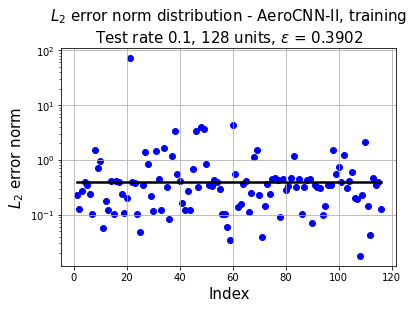

In [59]:
plt.plot(np.linspace(1,x_train.shape[0],x_train.shape[0]),
         l2_error_train*np.ones(x_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_train.shape[0], x_train.shape[0]), l2_error_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-II, training\nTest rate {0}, {1} units, $\epsilon$ = {2:0.4f}'.format(test_rate,
                                                                                                                         n_units,
                                                                                                                         l2_error_train), fontsize=15)
plt.grid()
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

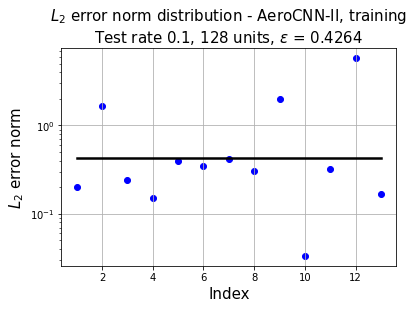

In [60]:
plt.plot(np.linspace(1,x_val.shape[0],x_val.shape[0]),
         l2_error_val*np.ones(x_val.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_val.shape[0], x_val.shape[0]), l2_error_val_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-II, training\nTest rate {0}, {1} units, $\epsilon$ = {2:0.4f}'.format(test_rate,
                                                                                                                         n_units,
                                                                                                                         l2_error_val), fontsize=15)
plt.grid()
saveName = "validationErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

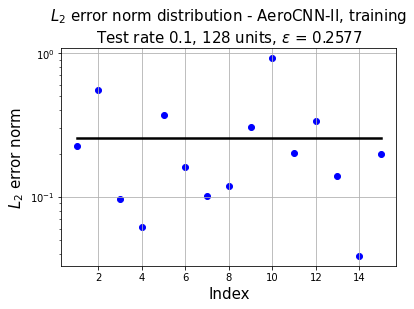

In [61]:
plt.plot(np.linspace(1,x_test.shape[0],x_test.shape[0]),
         l2_error_test*np.ones(x_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_test.shape[0], x_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-II, training\nTest rate {0}, {1} units, $\epsilon$ = {2:0.4f}'.format(test_rate,
                                                                                                                         n_units,
                                                                                                                         l2_error_test), fontsize=15)
plt.grid()
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

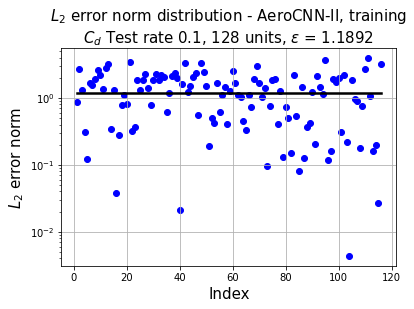

In [62]:
plt.plot(np.linspace(1,x_train.shape[0],x_train.shape[0]),
         l2_error_Cd_train*np.ones(x_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_train.shape[0], x_train.shape[0]), l2_error_train_Cd_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-II, training\n$C_d$ Test rate {0}, {1} units, $\epsilon$ = {2:0.4f}'.format(test_rate,
                                                                                                                         n_units,
                                                                                                                         l2_error_Cd_train), fontsize=15)
plt.grid()
saveName = "CdtrainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

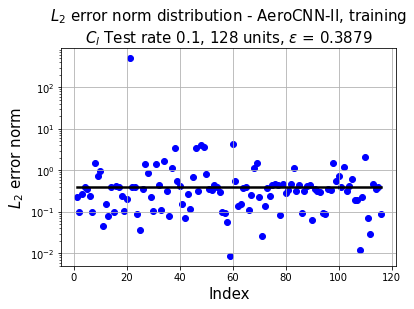

In [63]:
plt.plot(np.linspace(1,x_train.shape[0],x_train.shape[0]),
         l2_error_Cl_train*np.ones(x_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_train.shape[0], x_train.shape[0]), l2_error_train_Cl_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-II, training\n$C_l$ Test rate {0}, {1} units, $\epsilon$ = {2:0.4f}'.format(test_rate,
                                                                                                                         n_units,
                                                                                                                         l2_error_Cl_train), fontsize=15)
plt.grid()
saveName = "CltrainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

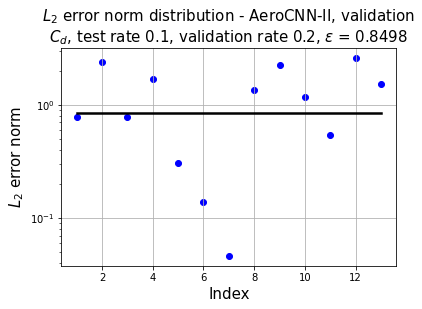

In [64]:
plt.plot(np.linspace(1,x_val.shape[0],x_val.shape[0]),
         l2_error_Cd_val*np.ones(x_val.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_val.shape[0], x_val.shape[0]), l2_error_val_Cd_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-II, validation\n$C_d$, test rate {0}, validation rate {1}, $\epsilon$ = {2:0.4f}'.format(test_rate,
                                                                                                                                            val_rate,
                                                                                                                                            l2_error_Cd_val), fontsize=15)
plt.grid()
saveName = "CdvalidationErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

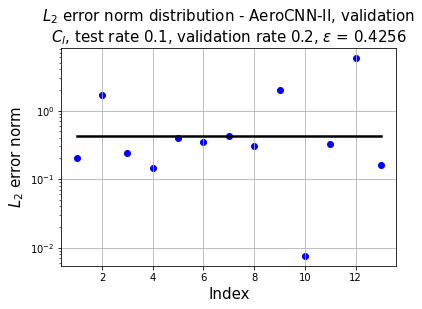

In [65]:
plt.plot(np.linspace(1,x_val.shape[0],x_val.shape[0]),
         l2_error_Cl_val*np.ones(x_val.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_val.shape[0], x_val.shape[0]), l2_error_val_Cl_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-II, validation\n$C_l$, test rate {0}, validation rate {1}, $\epsilon$ = {2:0.4f}'.format(test_rate, 
                                                                                                                                            val_rate,
                                                                                                                                            l2_error_Cl_val), fontsize=15)
plt.grid()
saveName = "ClvalidationErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

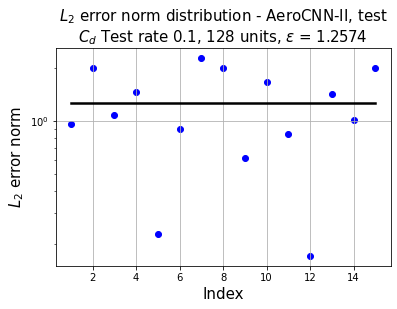

In [66]:
plt.plot(np.linspace(1,x_test.shape[0],x_test.shape[0]),
         l2_error_Cd_test*np.ones(x_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_test.shape[0], x_test.shape[0]), l2_error_test_Cd_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-II, test\n$C_d$ Test rate {0}, {1} units, $\epsilon$ = {2:0.4f}'.format(test_rate,
                                                                                                                           n_units,
                                                                                                                           l2_error_Cd_test), fontsize=15)
plt.grid()
saveName = "CdtestErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

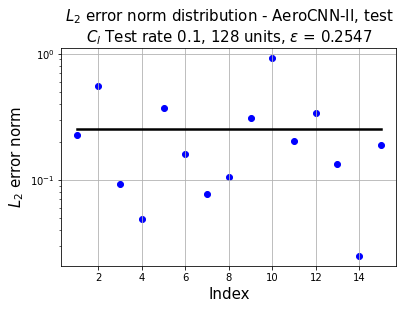

In [67]:
plt.plot(np.linspace(1,x_test.shape[0],x_test.shape[0]),
         l2_error_Cl_test*np.ones(x_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_test.shape[0], x_test.shape[0]), l2_error_test_Cl_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - AeroCNN-II, test\n$C_l$ Test rate {0}, {1} units, $\epsilon$ = {2:0.4f}'.format(test_rate,
                                                                                                                           n_units,
                                                                                                                           l2_error_Cl_test), fontsize=15)
plt.grid()
saveName = "CltestErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()